In [2]:
# Loading libraries for the course
from skimage import io as ski_io
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
import skimage as ski
from matplotlib import animation            # Module to plot animations
from skimage.filters import difference_of_gaussians
from skimage import io, measure               # Module from skimage
from cellpose import models

Cell size, area, 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as ski_io
from cellpose import models
import pandas as pd

# Load the image
figName = './Drug2_1000nM/rep1_FOV1.tif'
img = ski_io.imread(figName)

# Initialize Cellpose models
model_cyto = models.Cellpose(gpu=False, model_type='cyto')
model_nuclei = models.Cellpose(gpu=False, model_type='nuclei')

# Create an empty DataFrame to store results
df_merged_all_frames = pd.DataFrame(columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes'])

# Iterate over frames

for selected_frame in range(len(img)):
    # Select the appropriate frame and color channel
    img_to_analyze = img[selected_frame, :, :, 1]  # Assuming channel 1 for cytoplasm detection

    # Run Cellpose for cytoplasm detection
    masks_cyto, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

    if selected_frame == 0:
        mask_initial_cyto = masks_cyto

    masks_cyto = np.where(masks_cyto != 0, (masks_cyto * mask_initial_cyto) / masks_cyto, 0)
    
    # Prepare data for the cytoplasm DataFrame
    data_cyto = []
    for cell_id in np.unique(masks_cyto):
        mask = masks_cyto == cell_id
        sum_pix_intensity = img_to_analyze[mask].sum()
        cell_sizes = np.sum(mask)

        data_cyto.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

    df_cyto = pd.DataFrame(data_cyto, columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'cell sizes'])

    img_to_analyze = img[selected_frame, :, :, 0]  # Assuming channel 0 for nuclei detection

    # Run Cellpose for nuclei detection
    masks_nuclei, _, _, _ = model_nuclei.eval(img_to_analyze, diameter=None, channels=[0, 0])

    if selected_frame == 0:
        mask_initial_nuclei = masks_nuclei
        

    masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)

    # Prepare data for the nuclei DataFrame
    data_nuclei = []
    for cell_id in np.unique(masks_nuclei):
        mask = masks_nuclei == cell_id
        nucleus_sizes = np.sum(mask)
        sum_pix_intensity = img_to_analyze[mask].sum()

        data_nuclei.append([selected_frame, cell_id, nucleus_sizes, sum_pix_intensity])

    df_nuclei = pd.DataFrame(data_nuclei, columns=['time', 'cell_ID', 'nucleus sizes', 'sum_pix_intensity_nuclei'])

    # Merge the Cytoplasm and Nuclei DataFrames based on the 'cell' column
    df_merged = pd.merge(df_cyto, df_nuclei, on='cell_ID')
    df_merged['time'] = df_merged['time_x']
    df_merged = df_merged.drop(columns=['time_x', 'time_y'])
    df_merged = df_merged[['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes']]
    df_merged['protein concentrations (AU)'] = (df_merged['sum_pix_intensity_cyto'] - df_merged['sum_pix_intensity_nuclei']) / (df_merged['cell sizes'] - df_merged['nucleus sizes'])

    # Concatenate DataFrames instead of using append
    frames = [df_merged_all_frames, df_merged]
    df_merged_all_frames = pd.concat(frames, ignore_index=True)
    df_merged_all_frames = df_merged_all_frames[df_merged_all_frames['cell_ID'] != 0]

    

# Display the merged DataFrame for all frames
print("Merged DataFrame for all frames:")
print(df_merged_all_frames)

Basic analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as ski_io
from skimage.filters import difference_of_gaussians
from skimage import measure
from cellpose import models
import pandas as pd

# Load the image
figName = './Drug2_1000nM/rep1_FOV1.tif'
img = ski_io.imread(figName)

# Initialize Cellpose models
model_cyto = models.Cellpose(gpu=False, model_type='cyto')
model_nuclei = models.Cellpose(gpu=False, model_type='nuclei')

# Create an empty DataFrame to store results
df_merged_all_frames = pd.DataFrame(columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes', 'Particles in cytosol', 'Particles in nucleus'])

# Iterate over frames
for selected_frame in range(len(img)):
    # Select the appropriate frame and color channel
    img_to_analyze = img[selected_frame, :, :, 1]  # Assuming channel 1 for cytoplasm detection

    # Run Cellpose for cytoplasm detection
    masks_cyto, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

    if selected_frame == 0:
        mask_initial_cyto = masks_cyto

    masks_cyto = np.where(masks_cyto != 0, (masks_cyto * mask_initial_cyto) / masks_cyto, 0)
    
    # Prepare data for the cytoplasm DataFrame
    data_cyto = []
    for cell_id in np.unique(masks_cyto):
        if cell_id == 0:
            continue  # Skip background
        mask = masks_cyto == cell_id
        sum_pix_intensity = img_to_analyze[mask].sum()
        cell_sizes = np.sum(mask)

        data_cyto.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

    df_cyto = pd.DataFrame(data_cyto, columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'cell sizes'])

    img_to_analyze = img[selected_frame, :, :, 0]  # Assuming channel 0 for nuclei detection

    # Run Cellpose for nuclei detection
    masks_nuclei, _, _, _ = model_nuclei.eval(img_to_analyze, diameter=None, channels=[0, 0])

    if selected_frame == 0:
        mask_initial_nuclei = masks_nuclei

    masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)

    # Prepare data for the nuclei DataFrame
    data_nuclei = []
    for cell_id in np.unique(masks_nuclei):
        if cell_id == 0:
            continue  # Skip background
        mask = masks_nuclei == cell_id
        nucleus_sizes = np.sum(mask)
        sum_pix_intensity = img_to_analyze[mask].sum()

        data_nuclei.append([selected_frame, cell_id, nucleus_sizes, sum_pix_intensity])

    df_nuclei = pd.DataFrame(data_nuclei, columns=['time', 'cell_ID', 'nucleus sizes', 'sum_pix_intensity_nuclei'])

    # Merge the Cytoplasm and Nuclei DataFrames based on the 'cell' column
    df_merged = pd.merge(df_cyto, df_nuclei, on='cell_ID')
    df_merged['time'] = df_merged['time_x']
    df_merged = df_merged.drop(columns=['time_x', 'time_y'])
    df_merged = df_merged[['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes']]
    df_merged['protein concentrations (AU)'] = (df_merged['sum_pix_intensity_cyto'] - df_merged['sum_pix_intensity_nuclei']) / (df_merged['cell sizes'] - df_merged['nucleus sizes'])

    # Concatenate DataFrames instead of using append
    frames = [df_merged_all_frames, df_merged]
    df_merged_all_frames = pd.concat(frames, ignore_index=True)
    df_merged_all_frames = df_merged_all_frames[df_merged_all_frames['cell_ID'] != 0]

    # Analyze RNA spots
    selected_color_channel = 2
    img_to_analyze = img[selected_frame, :, :, selected_color_channel]

    # Apply a difference of Gaussians filter to the image to enhance spots
    img_spots_filtered = difference_of_gaussians(img_to_analyze, low_sigma=1, high_sigma=5)
    
    # Apply a threshold to the image to create binary image
    threshold = 0.05
    img_spots_binary = np.where(img_spots_filtered >= threshold, 1, 0)

    spot_contours = measure.find_contours(img_spots_binary, 0.5)

    number_detected_cells = np.max(mask_initial_cyto)
    list_cytosol_particles = np.zeros(number_detected_cells)
    list_nuclear_particles = np.zeros(number_detected_cells)

    # Loop through the spot contours
    for contour in spot_contours:
        # Find the position of the particle
        posn = np.mean(contour, axis=0).astype(int)

        # Ensure the position is within the image bounds
        if posn[0] >= img_spots_binary.shape[0] or posn[1] >= img_spots_binary.shape[1]:
            continue
        
        # Check which cyto mask the particle is in
        cell_num = mask_initial_cyto[posn[0], posn[1]]
        if cell_num > 0:
            list_cytosol_particles[cell_num - 1] += 1

            # Check if the particle is also in the nucleus
            if mask_initial_nuclei[posn[0], posn[1]] == cell_num:
                list_nuclear_particles[cell_num - 1] += 1

        # Analyze RNA spots
        selected_color_channel = 2
        img_to_analyze = img[selected_frame, :, :, selected_color_channel]

        # Apply a difference of Gaussians filter to the image to enhance spots
        img_spots_filtered = difference_of_gaussians(img_to_analyze, low_sigma=1, high_sigma=5)
        
        # Apply a threshold to the image to create a binary image
        threshold = 0.05
        img_spots_binary = np.where(img_spots_filtered >= threshold, 1, 0)

        spot_contours = measure.find_contours(img_spots_binary, 0.5)

        number_detected_cells = np.max(mask_initial_cyto)
        list_cytosol_particles = np.zeros(number_detected_cells)
        list_nuclear_particles = np.zeros(number_detected_cells)

        # Loop through the spot contours
        for contour in spot_contours:
            # Find the position of the particle
            posn = np.mean(contour, axis=0).astype(int)

            # Ensure the position is within the image bounds
            if posn[0] >= img_spots_binary.shape[0] or posn[1] >= img_spots_binary.shape[1]:
                continue
            
            # Check which cyto mask the particle is in
            cell_num = mask_initial_cyto[posn[0], posn[1]]
            if cell_num > 0:
                list_cytosol_particles[cell_num - 1] += 1

                # Check if the particle is also in the nucleus
                if mask_initial_nuclei[posn[0], posn[1]] == cell_num:
                    list_nuclear_particles[cell_num - 1] += 1



        # Analyze transcription sites
        selected_color_channel = 2
        img_to_analyze = img[selected_frame, :, :, selected_color_channel]

        # Apply a difference of Gaussians filter to the image to enhance spots
        img_spots_filtered = difference_of_gaussians(img_to_analyze, low_sigma=1, high_sigma=5)
        
        # Apply a threshold to the image to create a binary image
        threshold = 0.09
        img_spots_binary = np.where(img_spots_filtered >= threshold, 1, 0)

        spot_contours = measure.find_contours(img_spots_binary, 0.5)

        number_detected_cells = np.max(mask_initial_cyto)
        list_transcription_sites = np.zeros(number_detected_cells)
        list_position_transcription_sites = np.zeros(number_detected_cells)

        # Loop through the spot contours
        for contour in spot_contours:
            # Find the position of the particle
            posn = np.mean(contour, axis=0).astype(int)

            # Ensure the position is within the image bounds
            if posn[0] >= img_spots_binary.shape[0] or posn[1] >= img_spots_binary.shape[1]:
                continue
            
            # Check which nuclei mask the particle is in
            cell_num = mask_initial_nuclei[posn[0], posn[1]]
            if cell_num > 0:
                list_transcription_sites[cell_num - 1] += 1
                #count the intensity of the transcription sites
                intensity_transcription_sites = img_to_analyze[posn[0], posn[1]]


            #create a list with the position of the transcription sites and number of transcription sites
            list_position_transcription_sites[cell_num - 1] += posn[0]
            list_position_transcription_sites[cell_num - 1] += posn[1]

                           

        

        # Add the number of particles to the merged DataFrame
        df_merged['Particles in cytosol'] = list_cytosol_particles[df_merged['cell_ID'].astype(int) - 1]
        df_merged['Particles in nucleus'] = list_nuclear_particles[df_merged['cell_ID'].astype(int) - 1]

        df_merged['Transcription sites'] = list_transcription_sites[df_merged['cell_ID'].astype(int) - 1]
        df_merged['Position transcription sites'] = list_position_transcription_sites[df_merged['cell_ID'].astype(int) - 1]

    # Add the number of particles to the merged DataFrame


    # Concatenate DataFrames instead of using append
    df_merged_all_frames = pd.concat([df_merged_all_frames, df_merged], ignore_index=True)
    df_merged_all_frames.dropna(inplace=True)





C:\Users\daria\AppData\Local\Temp\ipykernel_53688\63480121.py:31: RuntimeWarning: invalid value encountered in divide
  masks_cyto = np.where(masks_cyto != 0, (masks_cyto * mask_initial_cyto) / masks_cyto, 0)
C:\Users\daria\AppData\Local\Temp\ipykernel_53688\63480121.py:54: RuntimeWarning: invalid value encountered in divide
  masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)
C:\Users\daria\AppData\Local\Temp\ipykernel_53688\63480121.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_merged_all_frames = pd.concat(frames, ignore_index=True)
C:\Users\daria\AppData\Local\Temp\ipykernel_53688\63480121.py:203: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

KeyboardInterrupt: 

Main function

In [6]:
import numpy as np
import pandas as pd
from skimage import measure
from skimage.filters import difference_of_gaussians
from cellpose import models

def DRUG_E(img, model_cyto, model_nuclei):
    # Create an empty DataFrame to store results
    df_merged_all_frames = pd.DataFrame(columns=[
        'time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 
        'cell sizes', 'nucleus sizes', 'Particles in cytosol', 'Particles in nucleus'
    ])

    transcription_data = []
    transcription_site_id = 1

    # Iterate over frames
    for selected_frame in range(len(img)):
        # Select the appropriate frame and color channel for cytoplasm detection
        img_to_analyze = img[selected_frame, :, :, 1]

        # Run Cellpose for cytoplasm detection
        masks_cyto, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

        if selected_frame == 0:
            mask_initial_cyto = masks_cyto

        masks_cyto = np.where(masks_cyto != 0, (masks_cyto * mask_initial_cyto) / masks_cyto, 0)
        
        # Prepare data for the cytoplasm DataFrame
        data_cyto = []
        for cell_id in np.unique(masks_cyto):
            if cell_id == 0:
                continue  # Skip background
            mask = masks_cyto == cell_id
            sum_pix_intensity = img_to_analyze[mask].sum()
            cell_sizes = np.sum(mask)

            data_cyto.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

        df_cyto = pd.DataFrame(data_cyto, columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'cell sizes'])

        # Select the appropriate frame and color channel for nuclei detection
        img_to_analyze = img[selected_frame, :, :, 0]

        # Run Cellpose for nuclei detection
        masks_nuclei, _, _, _ = model_nuclei.eval(img_to_analyze, diameter=None, channels=[0, 0])

        if selected_frame == 0:
            mask_initial_nuclei = masks_nuclei

        masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)

        # Prepare data for the nuclei DataFrame
        data_nuclei = []
        for cell_id in np.unique(masks_nuclei):
            if cell_id == 0:
                continue  # Skip background
            mask = masks_nuclei == cell_id
            nucleus_sizes = np.sum(mask)
            sum_pix_intensity = img_to_analyze[mask].sum()

            data_nuclei.append([selected_frame, cell_id, nucleus_sizes, sum_pix_intensity])

        df_nuclei = pd.DataFrame(data_nuclei, columns=['time', 'cell_ID', 'nucleus sizes', 'sum_pix_intensity_nuclei'])

        # Merge the Cytoplasm and Nuclei DataFrames based on the 'cell_ID' column
        df_merged = pd.merge(df_cyto, df_nuclei, on='cell_ID')
        df_merged['time'] = df_merged['time_x']
        df_merged = df_merged.drop(columns=['time_x', 'time_y'])
        df_merged = df_merged[['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes']]
        df_merged['protein concentrations (AU)'] = (
            df_merged['sum_pix_intensity_cyto'] - df_merged['sum_pix_intensity_nuclei']
        ) / (df_merged['cell sizes'] - df_merged['nucleus sizes'])

        # Concatenate DataFrames
        df_merged_all_frames = pd.concat([df_merged_all_frames, df_merged], ignore_index=True)

        # Analyze RNA spots
        selected_color_channel = 2
        img_to_analyze = img[selected_frame, :, :, selected_color_channel]

        # Apply a difference of Gaussians filter to the image to enhance spots
        img_spots_filtered = difference_of_gaussians(img_to_analyze, low_sigma=1, high_sigma=5)
        
        # Apply a threshold to the image to create a binary image
        threshold = 0.05
        img_spots_binary = np.where(img_spots_filtered >= threshold, 1, 0)

        spot_contours = measure.find_contours(img_spots_binary, 0.5)

        number_detected_cells = np.max(mask_initial_cyto)
        list_cytosol_particles = np.zeros(number_detected_cells)
        list_nuclear_particles = np.zeros(number_detected_cells)

        # Loop through the spot contours
        for contour in spot_contours:
            # Find the position of the particle
            posn = np.mean(contour, axis=0).astype(int)

            # Ensure the position is within the image bounds
            if posn[0] >= img_spots_binary.shape[0] or posn[1] >= img_spots_binary.shape[1]:
                continue
            
            # Check which cyto mask the particle is in
            cell_num = mask_initial_cyto[posn[0], posn[1]]
            if cell_num > 0:
                list_cytosol_particles[cell_num - 1] += 1

                # Check if the particle is also in the nucleus
                if mask_initial_nuclei[posn[0], posn[1]] == cell_num:
                    list_nuclear_particles[cell_num - 1] += 1

                # Collect transcription site data
                transcription_data.append({
                    'Time' : selected_frame,
                    'Transcription_Site_ID': transcription_site_id,
                    'Cell_ID': cell_num,
                    'Position_X': posn[0],
                    'Position_Y': posn[1],
                    'Intensity': img_to_analyze[posn[0], posn[1]]
                })
                transcription_site_id += 1

        # Add the number of particles to the merged DataFrame
        df_merged['Particles in cytosol'] = list_cytosol_particles[df_merged['cell_ID'].astype(int) - 1]
        df_merged['Particles in nucleus'] = list_nuclear_particles[df_merged['cell_ID'].astype(int) - 1]

        # Concatenate DataFrames
        df_merged_all_frames = pd.concat([df_merged_all_frames, df_merged], ignore_index=True)
        df_merged_all_frames.dropna(inplace=True)

    # Create a DataFrame for transcription sites
    df_transcription_sites = pd.DataFrame(transcription_data)

    return df_merged_all_frames, df_transcription_sites






In [7]:
img = ski_io.imread('./Drug2_1000nM/rep1_FOV1.tif')

# Load pre-trained Cellpose models
model_cyto = models.Cellpose(model_type='cyto')
model_nuclei = models.Cellpose(model_type='nuclei')

# Call the DRUG_E function
df_merged_all_frames, df_transcription_sites = DRUG_E(img, model_cyto, model_nuclei)

# Print the results
print("Merged DataFrame (Cell and RNA Spot Analysis):")
print(df_merged_all_frames.head())

print("\nTranscription Sites DataFrame:")
print(df_transcription_sites.head())

C:\Users\daria\AppData\Local\Temp\ipykernel_53688\892328404.py:28: RuntimeWarning: invalid value encountered in divide
  masks_cyto = np.where(masks_cyto != 0, (masks_cyto * mask_initial_cyto) / masks_cyto, 0)
C:\Users\daria\AppData\Local\Temp\ipykernel_53688\892328404.py:52: RuntimeWarning: invalid value encountered in divide
  masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)
C:\Users\daria\AppData\Local\Temp\ipykernel_53688\892328404.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_merged_all_frames = pd.concat([df_merged_all_frames, df_merged], ignore_index=True)
C:\Users\daria\AppData\Local\Temp\ipykernel_53688\892328404.py:130: FutureWarning: The behavior of DataFrame concatenati

Merged DataFrame (Cell and RNA Spot Analysis):
  time  cell_ID sum_pix_intensity_cyto sum_pix_intensity_nuclei cell sizes  \
0    0      1.0                1115782                   418168       8364   
1    0      2.0                 483785                   389275       7429   
2    0      3.0                 998611                   475839       7841   
3    0      4.0                 610883                   407425       7054   
4    0      5.0                 691100                   408913       7096   

  nucleus sizes  Particles in cytosol  Particles in nucleus  \
0          2551                   9.0                   1.0   
1          2391                   0.0                   0.0   
2          2897                  18.0                   5.0   
3          2496                   6.0                   1.0   
4          2508                  10.0                   3.0   

   protein concentrations (AU)  
0                   120.009290  
1                    18.759428  
2     

C:\Users\daria\AppData\Local\Temp\ipykernel_53688\892328404.py:52: RuntimeWarning: invalid value encountered in divide
  masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)


In [3]:
import numpy as np
import pandas as pd
from skimage.filters import difference_of_gaussians
from skimage import measure

# Select the frame and color channel
selected_frame = 4
selected_color_channel = 2
img_to_analyze = img[selected_frame, :, :, selected_color_channel]

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_to_analyze, low_sigma=1, high_sigma=5)

# Apply a threshold to the image to create a binary image
threshold = 0.09
img_spots_binary = np.where(img_spots_filtered >= threshold, 1, 0)

# Find contours in the binary image
spot_contours = measure.find_contours(img_spots_binary, 0.5)

# Initialize lists to keep track of transcription sites and their details
number_detected_cells = np.max(mask_initial_cyto)
list_transcription_sites = np.zeros(number_detected_cells, dtype=int)
list_position_transcription_sites = [[] for _ in range(number_detected_cells)]
list_intensity_transcription_sites = [[] for _ in range(number_detected_cells)]

# Loop through the spot contours
for contour in spot_contours:
    # Find the position of the particle
    posn = np.mean(contour, axis=0).astype(int)
    
    # Ensure the position is within the image bounds
    if posn[0] >= img_spots_binary.shape[0] or posn[1] >= img_spots_binary.shape[1]:
        continue
        
    # Check which nuclei mask the particle is in
    cell_num = mask_initial_nuclei[posn[0], posn[1]]
    if cell_num > 0:
        list_transcription_sites[cell_num - 1] += 1
        list_position_transcription_sites[cell_num - 1].append(posn)
        intensity_transcription_sites = img_to_analyze[posn[0], posn[1]]
        list_intensity_transcription_sites[cell_num - 1].append(intensity_transcription_sites)

# Create a list of dictionaries to construct the DataFrame
transcription_data = []
transcription_site_id = 1
for cell_id in range(number_detected_cells):
    for posn, intensity in zip(list_position_transcription_sites[cell_id], list_intensity_transcription_sites[cell_id]):
        transcription_data.append({
            'Transcription_Site_ID': transcription_site_id,
            'Cell_ID': cell_id + 1,
            'Position_X': posn[0],
            'Position_Y': posn[1],
            'Intensity': intensity
        })
        transcription_site_id += 1

# Create a DataFrame from the list of dictionaries
df_transcription_sites = pd.DataFrame(transcription_data)

Counting all images

In [ ]:
# Load all images and process them
image_directory = r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\Drug2_1000nM'
image_files = os.listdir(image_directory)
df_Drug2_1000nM = pd.DataFrame()

for image_file in image_files:
    if image_file.endswith('.tif'):
        image_path = os.path.join(image_directory, image_file)
        img = ski_io.imread(image_path)
        df_image = DRUG_E(img, model_cyto, model_nuclei)
        df_image['image_name'] = image_file
        df_Drug2_1000nM = pd.concat([df_Drug2_1000nM, df_image], ignore_index=True)

# Save the merged DataFrame to a CSV file
csv_file_path = 'df_Drug2_1000nM .csv'
df_all_images.to_csv(csv_file_path, index=False)


In [ ]:
image_directory = r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\Drug6_1000nM'
image_files = os.listdir(image_directory)
df_Drug6_1000nM = pd.DataFrame()

for image_file in image_files:
    if image_file.endswith('.tif'):
        image_path = os.path.join(image_directory, image_file)
        img = ski_io.imread(image_path)
        df_image = DRUG_E(img, model_cyto, model_nuclei)
        df_image['image_name'] = image_file
        df_Drug6_1000nM = pd.concat([df_Drug6_1000nM, df_image], ignore_index=True)

# Save the merged DataFrame to a CSV file
csv_file_path = 'df_Drug6_1000nM .csv'
df_all_images.to_csv(csv_file_path, index=False)



In [ ]:
image_directory = r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\Drug7_1000nM'
image_files = os.listdir(image_directory)
df_Drug7_1000nM = pd.DataFrame()

for image_file in image_files:
    if image_file.endswith('.tif'):
        image_path = os.path.join(image_directory, image_file)
        img = ski_io.imread(image_path)
        df_image = DRUG_E(img, model_cyto, model_nuclei)
        df_image['image_name'] = image_file
        df_Drug7_1000nM = pd.concat([df_Drug7_1000nM, df_image], ignore_index=True)

# Save the merged DataFrame to a CSV file
csv_file_path = 'df_Drug7_1000nM .csv'
df_all_images.to_csv(csv_file_path, index=False)

Starts Stats analysis

In [25]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.pyplot as plt
import numpy.random as rng
import scipy.stats as stats
# Uncomment the following the first time if you do not have seaborn installed:
#!pip install seaborn
import seaborn as sns
from typing import Union # for code annotation


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# Load the data
df = pd.read_csv('C:\\Users\\daria\\OneDrive - Politechnika Śląska\\QBio\\CourseMaterials\\uqbio2024\\UQbio2024_Team6\\df_Drug2_1000nM .csv')  

# Convert relevant columns to numeric data types, coercing errors
df['cell sizes'] = pd.to_numeric(df['cell sizes'], errors='coerce')
df['nucleus sizes'] = pd.to_numeric(df['nucleus sizes'], errors='coerce')
df['protein concentrations (AU)'] = pd.to_numeric(df['protein concentrations (AU)'], errors='coerce')
df['Particles in cytosol'] = pd.to_numeric(df['Particles in cytosol'], errors='coerce')
df['Particles in nucleus'] = pd.to_numeric(df['Particles in nucleus'], errors='coerce')

print(df.head())


   time  cell_ID  sum_pix_intensity_cyto  sum_pix_intensity_nuclei  \
0     0      1.0                 1115782                    418168   
1     0      2.0                  483785                    389275   
2     0      3.0                  998611                    475839   
3     0      4.0                  610883                    407425   
4     0      5.0                  691100                    408913   

   cell sizes  nucleus sizes  Particles in cytosol  Particles in nucleus  \
0        8364           2551                   9.0                   1.0   
1        7429           2391                   0.0                   0.0   
2        7841           2897                  18.0                   5.0   
3        7054           2496                   6.0                   1.0   
4        7096           2508                  10.0                   3.0   

   protein concentrations (AU)     image_name  
0                   120.009290  rep1_FOV1.tif  
1                    18.75

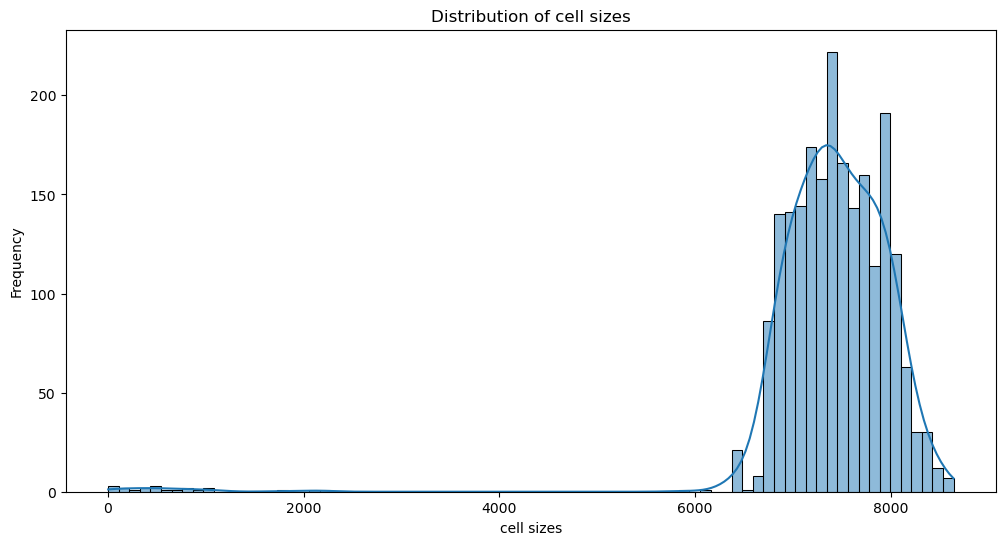

ValueError: Could not interpret value `drug` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['cell sizes', 'cell vitality', 'protein concentrations (AU)', 'Particles in cytosol', 'Particles in nucleus']

for feature in features:
    plt.figure(figsize=(12, 6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='drug', y=feature)
    plt.title(f'{feature} by Drug Treatment')
    plt.xlabel('Drug')
    plt.ylabel(feature)
    plt.show()

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
     0      1    1324.9638    1.0 -186423.7151 189073.6427  False
     0      2   20234.7605    1.0 -167896.6637 208366.1848  False
     0      3   20765.4889    1.0 -167754.1591 209285.1368  False
     0      4    32406.511    1.0 -156113.1369 220926.1589  False
     0      5  -14771.4273    1.0 -207503.1576  177960.303  False
     0      6  -13666.9455    1.0 -208759.2606 181425.3696  False
     0      7  -21595.0024    1.0 -217685.8515 174495.8468  False
     0      8  -28931.5552    1.0 -226054.3599 168191.2496  False
     0      9  -28638.6845    1.0 -225761.4893 168484.1202  False
     0     10  -27740.2795    1.0 -224863.0843 169382.5253  False
     0     11    -503.3853    1.0 -198693.3185  197686.548  False
     0     12  -28922.1252    1.0 -228216.2384  170371.988  False
     0    

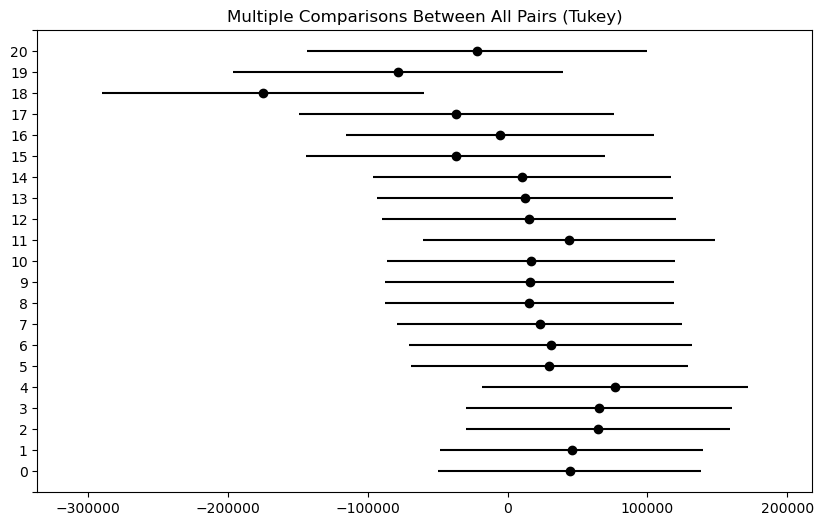

In [23]:
for feature in features:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='time', y=feature, hue='drug', marker='o')
    plt.title(f'Trend of {feature} over Time by Drug Treatment')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend(title='Drug')
    plt.show()


In [ ]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for feature in features:
    print(f"\nAnalyzing {feature}...")
    
    # Perform one-way ANOVA
    groups = [df[df['drug'] == drug][feature].dropna() for drug in df['drug'].unique()]
    f_statistic, p_value = f_oneway(*groups)
    print(f'F-statistic: {f_statistic}, p-value: {p_value}')
    
    # If significant, perform Tukey's HSD
    if p_value < 0.05:
        print(f"Significant differences found for {feature}. Performing Tukey's HSD post hoc test.")
        tukey_results = pairwise_tukeyhsd(df[feature], df['drug'], alpha=0.05)
        print(tukey_results)
        tukey_results.plot_simultaneous()
        plt.title(f"Tukey's HSD for {feature}")
        plt.show()
    else:
        print(f"No significant differences found for {feature}.")



Analyzing cell sizes...
F-statistic: 1.2418839932113104, p-value: 0.2092612903441385
No significant differences found for cell sizes.

Analyzing nucleus sizes...
F-statistic: 0.12896764878493672, p-value: 0.9999988719754019
No significant differences found for nucleus sizes.

Analyzing protein concentrations (AU)...
F-statistic: 1.6767637805112563, p-value: 0.03036933172458016
Significant differences found for protein concentrations (AU). Performing Tukey's HSD post hoc test.
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
     0      1    1324.9638    1.0 -186423.7151 189073.6427  False
     0      2   20234.7605    1.0 -167896.6637 208366.1848  False
     0      3   20765.4889    1.0 -167754.1591 209285.1368  False
     0      4    32406.511    1.0 -156113.1369 220926.1589  False
     0      5  -14771.4273    1.0 -207503.1576  177960.3

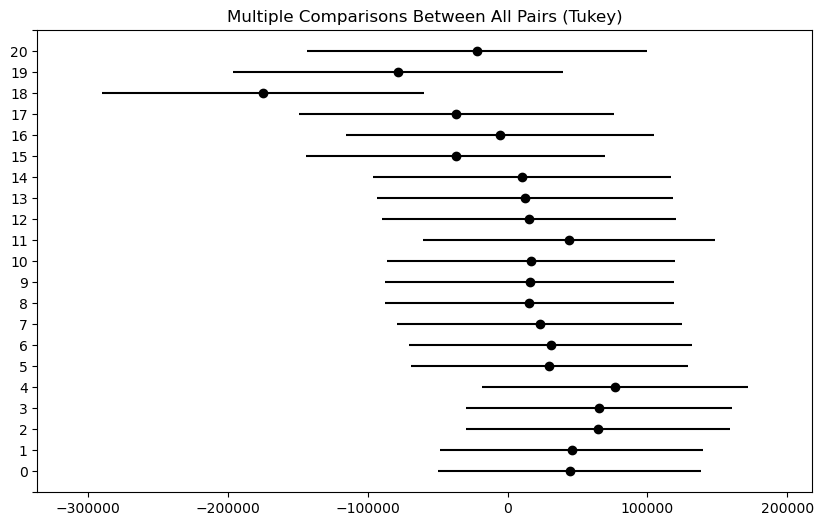


Analyzing Particles in cytosol...
F-statistic: 1.7015566641269313, p-value: 0.026776914016348168
Significant differences found for Particles in cytosol. Performing Tukey's HSD post hoc test.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1    0.043    1.0 -2.4867 2.5726  False
     0      2  -0.1491    1.0  -2.684 2.3857  False
     0      3   0.4343    1.0 -2.1058 2.9744  False
     0      4   0.6556    1.0 -1.8845 3.1957  False
     0      5   0.5916    1.0 -2.0052 3.1885  False
     0      6  -0.2159    1.0 -2.8445 2.4128  False
     0      7   -0.747    1.0 -3.3891  1.895  False
     0      8  -0.9882 0.9993 -3.6442 1.6678  False
     0      9  -1.1241  0.996 -3.7801 1.5319  False
     0     10  -1.0367 0.9986 -3.6927 1.6192  False
     0     11   -0.833    1.0 -3.5033 1.8374  False
     0     12  -1.3785  0.963 -4.0637 1.3067  False
     0     13  -1.4504 0.940

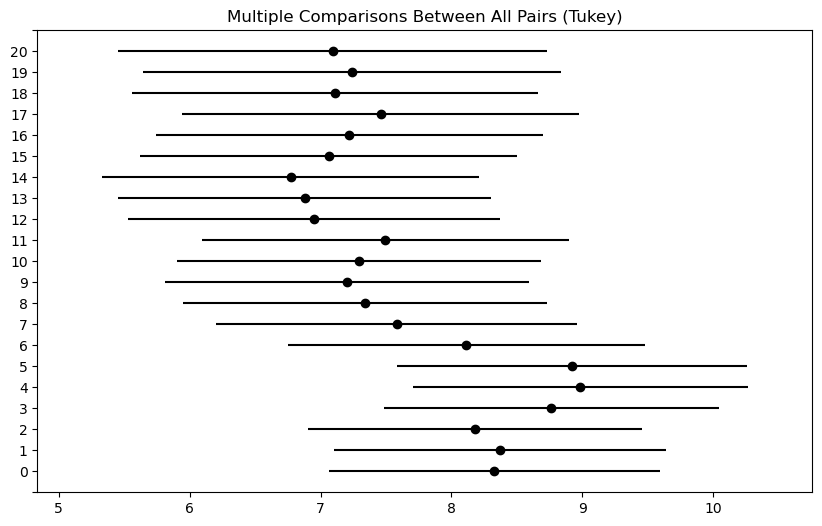


Analyzing Particles in nucleus...
F-statistic: 6.936849282485938, p-value: 4.516529468672369e-19
Significant differences found for Particles in nucleus. Performing Tukey's HSD post hoc test.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0571    1.0 -1.5014 1.6155  False
     0      2   0.1151    1.0 -1.4465 1.6767  False
     0      3   0.3134    1.0 -1.2514 1.8783  False
     0      4   0.3462    1.0 -1.2186 1.9111  False
     0      5   1.3664 0.2196 -0.2334 2.9662  False
     0      6   1.6209 0.0495  0.0015 3.2403   True
     0      7   1.6629 0.0387  0.0352 3.2906   True
     0      8     1.92  0.005  0.2837 3.5563   True
     0      9   1.9783  0.003   0.342 3.6145   True
     0     10    2.221 0.0003  0.5847 3.8572   True
     0     11   2.5141    0.0  0.8689 4.1592   True
     0     12   2.1826 0.0005  0.5283 3.8369   True
     0     13    2.022 0.002

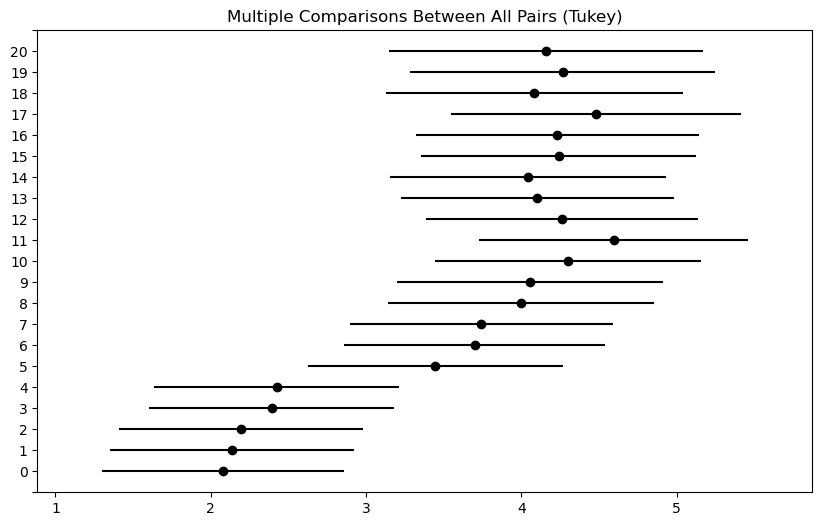

In [24]:
# Features to analyze
features = ['cell sizes', 'nucleus sizes', 'protein concentrations (AU)', 'Particles in cytosol', 'Particles in nucleus']

# Loop through each feature and perform ANOVA and Tukey's HSD test
for feature in features:
    print(f"\nAnalyzing {feature}...")
    
    # Perform one-way ANOVA
    groups = [df[df['time'] == time][feature].dropna() for time in time_points]
    f_statistic, p_value = f_oneway(*groups)
    print(f'F-statistic: {f_statistic}, p-value: {p_value}')
    
    # If significant, perform Tukey's HSD
    if p_value < 0.05:
        print(f"Significant differences found for {feature}. Performing Tukey's HSD post hoc test.")
        tukey_results = pairwise_tukeyhsd(df[feature], df['time'], alpha=0.05)
        print(tukey_results)
        tukey_results.plot_simultaneous()
        plt.show()
    else:
        print(f"No significant differences found for {feature}.")
